Protein-Protein Interaction (PPI) Prediction
This notebook explores the PPI dataset, validates the data integrity, and trains a Random Forest model using various class-imbalance techniques (Class Weights, SMOTE, and SMOTE-Tomek)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Set visualization style
sns.set_theme(style="whitegrid")

Data Loading and Validation

First, we load the dataset and perform sanity checks to ensure probabilities and surface accessibility values are within their expected logical ranges.

In [5]:
ppi_data = pd.read_csv("ppi.csv")
display(ppi_data.head())

def check_dataframe(ppi_data):
    
    prob_cols = [col for col in ppi_data.columns if 'prob_' in col]
    surf_cols = [col for col in ppi_data.columns if 'surf_acc' in col]

    #check if there's any NaN value in the dataset
    ppi_data.isnull().values.any()
    
    #chekc probbilities value correctness
    prob_issues = 0
    for col in prob_cols:
        invalid_count = ((ppi_data[col] < 0) | (ppi_data[col] > 1)).sum()
        if invalid_count > 0:
            print(f"{col}: {invalid_count} values outside 0 and 1")
            prob_issues += 1
            
    if prob_issues == 0:
        print("probability columns have all values within range")

    #chekc psurface values correctness
    surf_issues = 0
    for col in surf_cols:
        invalid_count = (ppi_data[col] < 0).sum()
        if invalid_count > 0:
            print(f"{col}: {invalid_count} negative values")
            surf_issues += 1
            
    if surf_issues == 0:
        print("Surface columns have all values within range")

print(check_dataframe(ppi_data))


,Unnamed: 0,domain,aa_ProtPosition,uniprot_id,Rlength,sequence,normalized_length,normalized_abs_surf_acc,normalized_hydropathy_index,rel_surf_acc,...,9_wm_pssm_K,9_wm_pssm_M,9_wm_pssm_F,9_wm_pssm_P,9_wm_pssm_S,9_wm_pssm_T,9_wm_pssm_W,9_wm_pssm_Y,9_wm_pssm_V,p_interface
0,0,0,1,A0A024RAV5,188,M,0.238095,0.784319,0.711111,0.803,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
1,1,0,2,A0A024RAV5,188,T,0.238095,0.359207,0.422222,0.530,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
2,2,0,3,A0A024RAV5,188,E,0.238095,0.395387,0.111111,0.464,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
3,3,0,4,A0A024RAV5,188,Y,0.238095,0.401655,0.355556,0.385,...,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0
4,4,1,5,A0A024RAV5,188,K,0.238095,0.288103,0.066667,0.287,...,0.302858,0.436017,0.238759,0.103980,0.105653,0.161544,0.060391,0.140326,0.481904,0


probability columns have all values within range
Surface columns have all values within range
None


Preprocessing and Train/Test Split

To prevent data leakage, we split the data based on unique proteins (`uniprot_id`) rather than randomized rows. 33% of the proteins are for testing, 66% for training.

In [6]:
# class imbalance for total datset
counts = ppi_data['p_interface'].value_counts()
percentages = ppi_data['p_interface'].value_counts(normalize=True) * 100
print(counts)
print(percentages)

# Get list of unique proteins (228 total)
unique_proteins = ppi_data['uniprot_id'].unique()

# Split proteins (33% test, 67% train)
train_ids, test_ids = train_test_split(unique_proteins, test_size=0.33, random_state=22)
train_data = ppi_data[ppi_data['uniprot_id'].isin(train_ids)]
test_data = ppi_data[ppi_data['uniprot_id'].isin(test_ids)]

# Drop features not used for modeling
cols_to_drop = ['p_interface', 'uniprot_id', 'domain', 'sequence', 'aa_ProtPosition', 'Unnamed: 0']
  
X_train = train_data.drop(columns=cols_to_drop)
y_train = train_data['p_interface']
X_test = test_data.drop(columns=cols_to_drop)
y_test = test_data['p_interface']

# Check class imbalance
print("--- TARGET CLASS IMBALANCE ---")
print(f"Train Balance:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\nTest Balance:\n{y_test.value_counts(normalize=True) * 100}")
print(f"\nShapes: X_train: {X_train.shape} | X_test: {X_test.shape}")


p_interface
0    57305
1     7845
Name: count, dtype: int64
p_interface
0    87.958557
1    12.041443
Name: proportion, dtype: float64
--- TARGET CLASS IMBALANCE ---
Train Balance:
p_interface
0    87.955821
1    12.044179
Name: proportion, dtype: float64

Test Balance:
p_interface
0    87.964179
1    12.035821
Name: proportion, dtype: float64

Shapes: X_train: (43822, 132) | X_test: (21328, 132)


In [7]:
#pre-processing

# get the list of all unique proteins (228 total)
unique_proteins = ppi_data['uniprot_id'].unique()

# takes 33% of the total proteins for test set, 67% in the training, n.22
train_ids, test_ids = train_test_split(unique_proteins, test_size=0.33, random_state=22)
train_data = ppi_data[ppi_data['uniprot_id'].isin(train_ids)]
test_data = ppi_data[ppi_data['uniprot_id'].isin(test_ids)]

# some fetaures have to be dropped
cols_to_drop = ['p_interface', 'uniprot_id', 'domain', 'sequence', 'aa_ProtPosition', 'Unnamed: 0']
  
X_train = train_data.drop(columns=cols_to_drop)
y_train = train_data['p_interface']

X_test = test_data.drop(columns=cols_to_drop)
y_test = test_data['p_interface']

# 1. Just call .value_counts() directly on the Series
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# 2. Get the proportions (percentages) to easily check the imbalance
train_props = y_train.value_counts(normalize=True) * 100
test_props = y_test.value_counts(normalize=True) * 100

# 3. Print everything out clearly
print("--- RAW COUNTS ---")
print("Train 0s and 1s:\n", train_counts, "Train Class Balance:\n", train_props)
print("\nTest 0s and 1s:\n", test_counts, "\nTest Class Balance:\n", test_props)

print("\nShapes:", X_train.shape, X_test.shape)

--- RAW COUNTS ---
Train 0s and 1s:
 p_interface
0    38544
1     5278
Name: count, dtype: int64 Train Class Balance:
 p_interface
0    87.955821
1    12.044179
Name: proportion, dtype: float64

Test 0s and 1s:
 p_interface
0    18761
1     2567
Name: count, dtype: int64 
Test Class Balance:
 p_interface
0    87.964179
1    12.035821
Name: proportion, dtype: float64

Shapes: (43822, 132) (21328, 132)


Model Training and Handling Imbalance

Because the `p_interface` target is highly imbalanced, we will evaluate a Random Forest classifier using three different techniques:
1. Built-in Class Weights
2. SMOTE (Synthetic Minority Over-sampling Technique)
3. SMOTE-Tomek (Over-sampling combined with under-sampling)

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=22, n_jobs=-1)
rf_balanced.fit(X_train, y_train)
pred_balanced = rf_balanced.predict(X_test)

smote = SMOTE(random_state=23)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=23, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote)
pred_smote = rf_smote.predict(X_test)

smt = SMOTETomek(random_state=24)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
rf_smt = RandomForestClassifier(n_estimators=100, random_state=24, n_jobs=-1)
rf_smt.fit(X_train_smt, y_train_smt)
pred_smt = rf_smt.predict(X_test)

print("Class Weight Balanced:")
print(classification_report(y_test, pred_balanced))
print("SMOTE:")
print(classification_report(y_test, pred_smote))
print("SMOTE Tomek:")
print(classification_report(y_test, pred_smt))

d:\Users\Huang\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Users\Huang\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "d:\Users\Huang\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Users\Huang\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
      

Class Weight Balanced:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     18761
           1       0.52      0.01      0.03      2567

    accuracy                           0.88     21328
   macro avg       0.70      0.51      0.48     21328
weighted avg       0.84      0.88      0.83     21328

SMOTE:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     18761
           1       0.27      0.07      0.12      2567

    accuracy                           0.87     21328
   macro avg       0.58      0.52      0.52     21328
weighted avg       0.81      0.87      0.83     21328

SMOTE Tomek:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     18761
           1       0.30      0.07      0.12      2567

    accuracy                           0.87     21328
   macro avg       0.59      0.53      0.52     21328
weighted avg       0.82      0.

In [ ]:

def evaluate_model(model, X_test, y_test):

    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "MCC": mcc,
        "F1": f1,
        "y_prob": y_prob
    }
results = {}

results["RF + class_weight"] = evaluate_model(rf_balanced, X_test, y_test)
results["RF + SMOTE"] = evaluate_model(rf_smote, X_test, y_test)
results["RF + SMOTETomek"] = evaluate_model(rf_smt, X_test, y_test)

summary_table = pd.DataFrame({
    method: {
        "ROC-AUC": results[method]["ROC-AUC"],
        "PR-AUC": results[method]["PR-AUC"],
        "MCC": results[method]["MCC"],
        "F1": results[method]["F1"],
    }
    for method in results
}).T

summary_table


,ROC-AUC,PR-AUC,MCC,F1
RF + class_weight,0.667985,0.212833,0.066629,0.027988
RF + SMOTE,0.678562,0.211580,0.094366,0.129630
RF + SMOTETomek,0.678528,0.210949,0.099679,0.128915


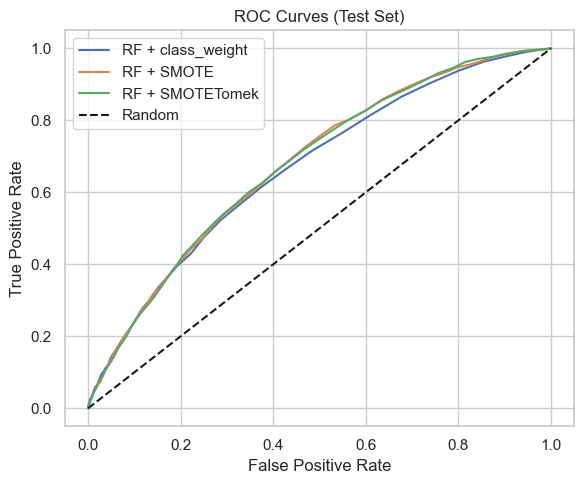

In [14]:
plt.figure(figsize=(6,5))

for method, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=method)

plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


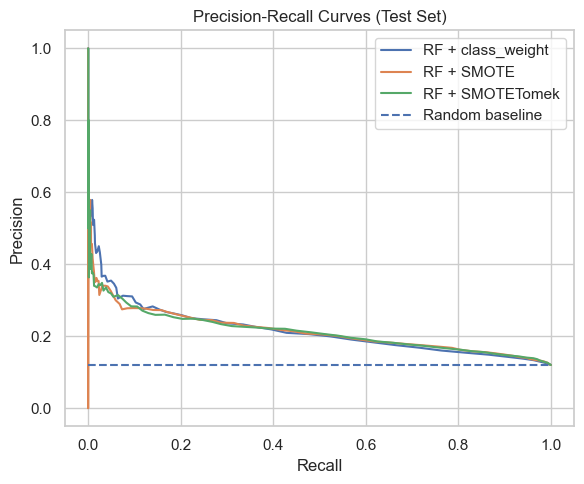

In [15]:
plt.figure(figsize=(6,5))

for method, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
    plt.plot(recall, precision, label=method)

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles='dashed', label="Random baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split

if "train_df" in globals() and "uniprot_id" in train_df.columns:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = train_df["uniprot_id"].values

    train_idx, val_idx = next(gss.split(train_df, train_df["p_interface"], groups=groups))

    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    print("Using protein-level validation split by uniprot_id.")
else:
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    print("Using random stratified validation split (fallback).")

print("Train:", X_tr.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Pos ratio train/val/test:", y_tr.mean(), y_val.mean(), y_test.mean())


Using random stratified validation split (fallback).
Train: (35057, 132) Val: (8765, 132) Test: (21328, 132)
Pos ratio train/val/test: 0.1204324385999943 0.12047917855105533 0.1203582145536384


In [21]:
%pip install -U xgboost


Note: you may need to restart the kernel to use updated packages.


In [ ]:

from xgboost import XGBClassifier


neg = (y_tr == 0).sum()
pos = (y_tr == 1).sum()
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric="aucpr"  
)

xgb.fit(X_tr, y_tr)


xgb_res = evaluate_model(xgb, X_test, y_test)
xgb_res



{'ROC-AUC': np.float64(0.6536659329448422),
 'PR-AUC': np.float64(0.20761157034499017),
 'MCC': np.float64(0.12749580780424263),
 'F1': 0.1922091235263967,
 'y_prob': array([0.01798877, 0.22152548, 0.11226311, ..., 0.09468345, 0.63055277,
        0.24757116], dtype=float32)}

In [27]:
import pandas as pd


if "results" in globals():
    results["XGBoost (scale_pos_weight + early stopping)"] = xgb_res

    summary_table = pd.DataFrame({
        method: {
            "ROC-AUC": results[method]["ROC-AUC"],
            "PR-AUC": results[method]["PR-AUC"],
            "MCC": results[method]["MCC"],
            "F1": results[method]["F1"],
        }
        for method in results
    }).T

    display(summary_table.sort_values("PR-AUC", ascending=False))
else:

    print(pd.DataFrame([{
        "Method": "XGBoost",
        "ROC-AUC": xgb_res["ROC-AUC"],
        "PR-AUC": xgb_res["PR-AUC"],
        "MCC": xgb_res["MCC"],
        "F1": xgb_res["F1"],
    }]))


,ROC-AUC,PR-AUC,MCC,F1
RF + class_weight,0.667985,0.212833,0.066629,0.027988
RF + SMOTE,0.678562,0.211580,0.094366,0.129630
RF + SMOTETomek,0.678528,0.210949,0.099679,0.128915
XGBoost (scale_pos_weight + early stopping),0.653666,0.207612,0.127496,0.192209


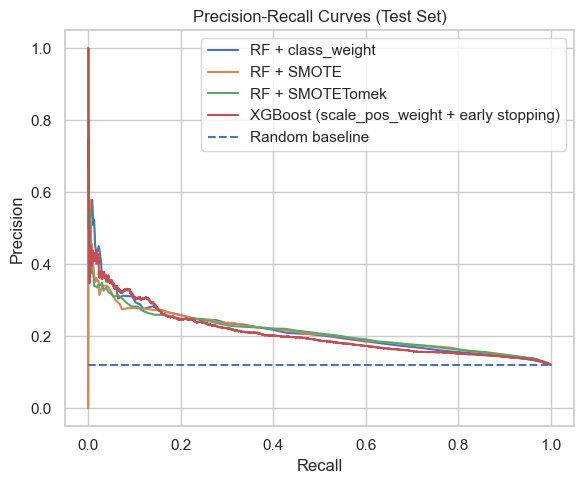

In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# PR curve
plt.figure(figsize=(6,5))

if "results" in globals():
    for method, res in results.items():
        precision, recall, _ = precision_recall_curve(y_test, res["y_prob"])
        plt.plot(recall, precision, label=method)
else:
    precision, recall, _ = precision_recall_curve(y_test, xgb_res["y_prob"])
    plt.plot(recall, precision, label="XGBoost")

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles='dashed', label="Random baseline")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()
